### Purpose of this notebook

1) contributions to the heating from all the terms as an example between the two years. what is the biggest term? by how much? 2) bar chart comparison of the gateway contributions between the two years. How much more did x contribute to the heating? 3) what water masses is this creating (divergence?) how much more volume?


In [1]:
# import the packages

# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [12]:
# set the correct directories based on official ASTE
forward_path = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirdiags = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/diags/BUDG/"
dirstate = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/diags/STATE/"

# layers path here is for what time steps?
layers_path2007 = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
layers_path2016 = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2016_capxxN50_it0062_pk0000736272_bro/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"


## choose a mask

We need to reset the gates based on wmt_spellout_bigaste.

We also need to refine/fix the ADV function in create_layers.py

Make a function to get the gates and write them for Barents Sea

For overall changes: probably best to use the whole Barents Sea

For focused WMT: maybe choose a subregion, and split by depth (Lind)

In [13]:
# cut off the edge of the Barents Sea that is should not be included
mymsk[:,84:110] = np.nan

# load the indices from file
data = np.load("/home/mmurakami/crios_backups/an_helper_functions/gates_BSO.npz")

y_bsoh, x_bsoh = data["y_bsoh"], data["x_bsoh"]
y_bsov, x_bsov = data["y_bsov"], data["x_bsov"]

y_fjnzv, x_fjnzv = data["y_fjnzv"], data["x_fjnzv"]
y_fjnz,  x_fjnz  = data["y_fjnz"],  data["x_fjnz"]

y_nzruv, x_nzruv = data["y_nzruv"], data["x_nzruv"]

y_spfjh, x_spfjh = data["y_spfjh"], data["x_spfjh"]
y_spfjv, x_spfjv = data["y_spfjv"], data["x_spfjv"]
y_spfjb, x_spfjb = data["y_spfjb"], data["x_spfjb"]

print("keys:", list(data.keys()))

keys: ['y_bsoh', 'x_bsoh', 'y_bsov', 'x_bsov', 'y_fjnzv', 'x_fjnzv', 'y_fjnz', 'x_fjnz', 'y_nzruv', 'x_nzruv', 'y_spfjh', 'x_spfjh', 'y_spfjv', 'x_spfjv', 'y_spfjb', 'x_spfjb']


In [14]:
# make a new line, spnz which will be for the N mask
# again this will be where we READ from, hence it will need to be included in the mask
y_spnz = np.arange(485,560,1)
x_spnz = np.full_like(y_spnz,45) 

In [15]:
mymsk2 = np.full_like(mymsk,np.nan)
mymsk2[mymsk == 1] = 1
mymsk2[:,:45] = np.nan

(0.0, 100.0)

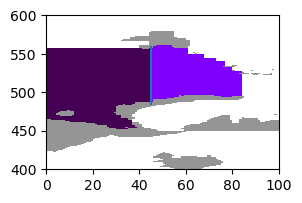

In [16]:
fig = plt.figure(figsize=(3,2))

ax = plt.subplot(111)
plt.pcolormesh(mymsk)
plt.pcolormesh(mymsk2,cmap='rainbow')
plt.pcolormesh(landmsk,cmap="Greys",vmin=0,vmax=4)
plt.plot(x_spnz,y_spnz)
ax.set_ylim(400,600)
ax.set_xlim(0,100)

### create the mask as iwet in a 1D array

This will help us to index in the layers output

In [17]:
iwet_mymsk = get_iwet_from_mymsk(mymsk,iwetC2d)
iwet_mymsk2 = get_iwet_from_mymsk(mymsk2,iwetC2d)

## Load the G terms and the gateways from layers

In [18]:
# let's move the gate calculation to a function to show a timeseries
# define tstep 
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times['2007'] = np.arange(1,3,1)
print(times)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstr

{'2007': array([1, 2])}


array(['0000262944', '0000267408'], dtype='<U32')

In [19]:
# add the TS bins
boundsT = np.round(np.squeeze(rdmds(layers_path + "layers2TH")).ravel(),1)
nT = boundsT.size - 1
boundsS = np.round(np.squeeze(rdmds(layers_path + "layers1SLT")).ravel(),1)
nS = boundsS.size - 1

binwidthT = boundsT[1:] - boundsT[:-1]
binwidthS = boundsS[1:] - boundsS[:-1]

binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])
binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])

binmidT = (boundsT[1:] + boundsT[:-1]) /2
binmidS = (boundsS[1:] + boundsS[:-1]) /2

nT = nT
nS = nS
nTm1 = nT-1
nSm1 = nS-1

## budget difference for the two years in T and S only

top: budgeted breakdown of the contributing terms -- what is the biggest term for each of the years? and by how much? i expect gates

bottom: bar chart comparison of the gate contribution to the heat individually

In [20]:
# load the G terms for the first mask (see ASTE_270/Pemberton_BarentsSpaper/2026_BarentsS/timeseriescontributions.ipynb)
from create_layers import get_G_terms
name = "BarentsS"
G_T,G_S = get_G_terms(layers_path,dirgridw,iwet_mine,tsstr,name,iwetC2d,LwetC2d,LwetC,hf1,nz,ny,nx)

RAC2d (146614,)
(4833023,)
24
24


In [22]:
# get the gateway transports for the same region
from create_layers import create_gates

G_BSOT,G_FJNZT,G_SPFJT,G_NZRUT, G_BSOS,G_FJNZS,G_SPFJS,G_NZRUS = create_gates(tsstr,mygrid,myparms,dirdiags,dirState,layers_path,mymsk,nz,ny,nx,nfx,nfy,y_bsoh,x_bsoh,y_bsov,x_bsov,y_fjnzv,x_fjnzv,y_nzruv,x_nzruv,y_spfjh,x_spfjh,y_spfjv,x_spfjv,y_spfjb,x_spfjb)

In [23]:
# G_S[name][tsstr[1]].keys()

In [24]:
MsumS = G_BSOS + G_FJNZS + G_SPFJS+ G_NZRUS   # overall transport in S
MsumT = G_BSOT + G_FJNZT + G_SPFJT + G_NZRUT  # overall transport in T
MsumS[np.isnan(MsumS)] = 0
MsumT[np.isnan(MsumT)] = 0

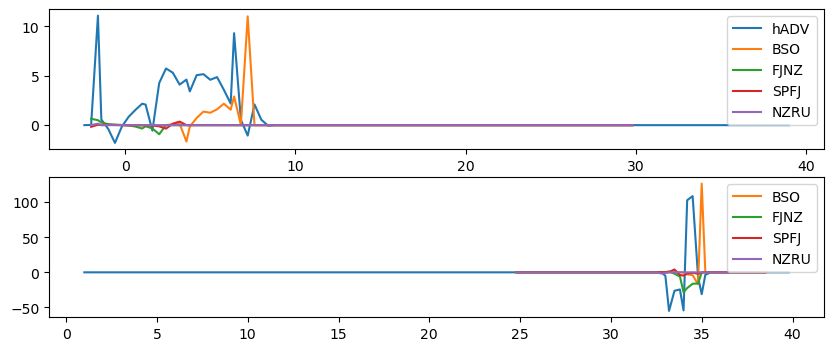

In [25]:
# create a plot to show these -- first just show the advective terms and the sum to show they are similar
# why bother
ffac = 1e-6

fig = plt.figure()

ax = plt.subplot(211)
ax.plot(boundsT.flatten()[1:-1],G_T[name][tsstr[1]]['LTha2TH'],label="hADV")
ax.plot(boundsT.flatten()[1:-1],G_BSOT*ffac,label="BSO")
ax.plot(boundsT.flatten()[1:-1],G_FJNZT*ffac,label="FJNZ")
ax.plot(boundsT.flatten()[1:-1],G_SPFJT*ffac,label="SPFJ")
ax.plot(boundsT.flatten()[1:-1],G_NZRUT*ffac,label="NZRU")
ax.legend(loc="best")


ax = plt.subplot(212)
ax.plot(boundsS.flatten()[1:-1],G_S[name][tsstr[1]]['LSha1SLT'])
ax.plot(boundsS.flatten()[1:-1],G_BSOS*ffac,label="BSO")
ax.plot(boundsS.flatten()[1:-1],G_FJNZS*ffac,label="FJNZ")
ax.plot(boundsS.flatten()[1:-1],G_SPFJS*ffac,label="SPFJ")
ax.plot(boundsS.flatten()[1:-1],G_NZRUS*ffac,label="NZRU")
ax.legend(loc="best")


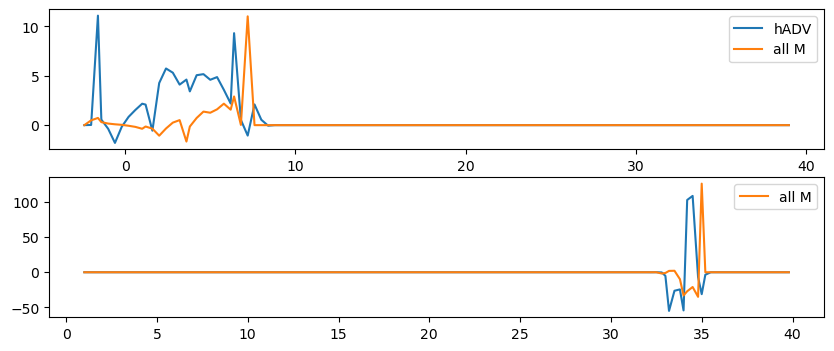

In [26]:
# create a plot to show these -- first just show the advective terms and the sum to show they are similar
# why bother
ffac = 1e-6

fig = plt.figure()

ax = plt.subplot(211)
ax.plot(boundsT.flatten()[1:-1],G_T[name][tsstr[1]]['LTha2TH'],label="hADV")
ax.plot(boundsT.flatten()[1:-1],MsumT*ffac,label="all M")
ax.legend(loc="best")


ax = plt.subplot(212)
ax.plot(boundsS.flatten()[1:-1],G_S[name][tsstr[1]]['LSha1SLT'])
ax.plot(boundsS.flatten()[1:-1],MsumS*ffac,label="all M")
ax.legend(loc="best")


In [27]:
print(np.nansum(G_T[name][tsstr[1]]['LTha2TH']))

79.7582668577301


In [29]:
print(np.nansum(MsumT*ffac))

20.929699185914867


### which term is most responsible for heat and salt changes at this time step

In [107]:
G_S[name][tsstr[1]].keys()

dict_keys(['LSto1SLT', 'LSza1SLT', 'LSha1SLT', 'LaSz1SLT', 'LaSh1SLT', 'LaSs1SLT', 'residS'])

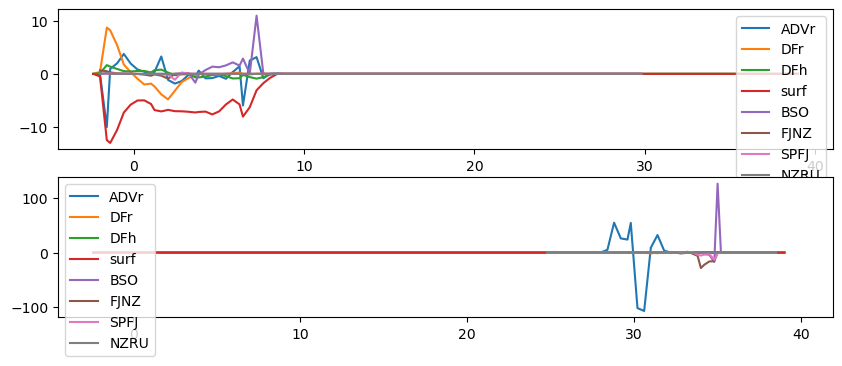

In [112]:
# create a plot to show these -- first just show the advective terms and the sum to show they are similar
# why bother
ffac = 1e-6

fig = plt.figure()
ax = plt.subplot(211)
keys = list(G_T[name][tsstr[1]].keys())
sel = [1, 3, 4, 5]
labels = np.array(["ADVr","DFr","DFh","surf"])
keys_to_plot = [keys[i] for i in sel]
x = boundsT.flatten()[1:-1]
i = 0
for k in keys_to_plot:
    y = np.asarray(G_T[name][tsstr[1]][k]).flatten()
    ax.plot(x, y, label=labels[i])
    i += 1
ax.plot(boundsT.flatten()[1:-1],G_BSOT*ffac,label="BSO")
ax.plot(boundsT.flatten()[1:-1],G_FJNZT*ffac,label="FJNZ")
ax.plot(boundsT.flatten()[1:-1],G_SPFJT*ffac,label="SPFJ")
ax.plot(boundsT.flatten()[1:-1],G_NZRUT*ffac,label="NZRU")
ax.legend(loc="best")


ax = plt.subplot(212)
keys = list(G_S[name][tsstr[1]].keys())
sel = [1, 3, 4, 5]
labels = np.array(["ADVr","DFr","DFh","surf"])
keys_to_plot = [keys[i] for i in sel]
x = boundsT.flatten()[1:-1]
i = 0
for k in keys_to_plot:
    y = np.asarray(G_S[name][tsstr[1]][k]).flatten()
    ax.plot(x, y, label=labels[i])
    i += 1
ax.plot(boundsS.flatten()[1:-1],G_BSOS*ffac,label="BSO")
ax.plot(boundsS.flatten()[1:-1],G_FJNZS*ffac,label="FJNZ")
ax.plot(boundsS.flatten()[1:-1],G_SPFJS*ffac,label="SPFJ")
ax.plot(boundsS.flatten()[1:-1],G_NZRUS*ffac,label="NZRU")
ax.legend(loc="best")

### over all timesteps -- which term is most responsible for the positive or negative changes

Note: An doesn't like this because it collapses details, is there a different way we cannot do time averaging for this?

### We need to develop a climatology for the 2005--2017 ASTE period with the G terms

In [ ]:
# we need to calculate the G terms and the gateways for this period

## what water masses is this creating?